# Data Prep

Using file `data_prep.py` for prepping the data in the same way like `eda.ipynb`

In [77]:
from data_prep import prepare_data
import numpy as np

# Optional: reproducible fuzzy scores
np.random.seed(42)

df, df_homepage, df_misinfo = prepare_data(
    id_file=r"../data/final_combined_results_2937495-7229337.json",
    homepage_file=r"../data/homepage_posts_data.json",
    misinfo_file=r"../data/mssinfo_wykop_posts.json",
)

print(df.shape, df_homepage.shape, df_misinfo.shape)
print(df[['text', 'scores', 'scores_fuzzy']].head())

(12259, 10) (9863, 9) (2832, 12)
                                                text  scores  scores_fuzzy
0  We Francji spokojnie. W sylwestra spalono tylk...     1.0      0.989100
1  [Afera Prezydencka] Moderator fDy A gdyby tak ...     1.0      0.998437
2  Szczera wypowiedź Tomasza Lisa pan redaktor w ...     1.0      1.000000
3  Inwazja zombie-islamu na Europę stała się fakt...     1.0      1.000000
4  Czy tak wyglądały ataki w Koloni  w Nowy Rok? ...     1.0      1.000000


In [78]:
rounding_conditions = [
    df['scores'] < 0.35,
    (df['scores'] >= 0.35) & (df['scores'] < 0.85),
    df['scores'] >= 0.85
]

rounding_choices = [0, 0.7, 1]

df['scores'] = np.select(rounding_conditions, rounding_choices)


In [79]:
# For classification - 3 classes
df["label"] = df["scores"].apply(lambda x: 0 if x < 0.35 else (2 if x > 0.85 else 1))

df = df[~df['clean_text'].duplicated()].reset_index(drop=True)
df["label"].value_counts(normalize=True)

label
0    0.578320
2    0.227071
1    0.194609
Name: proportion, dtype: float64

In [80]:
# For classification - 2 classes
df_2c = df.copy()
df_2c["label"] = df_2c["scores"].apply(lambda x: 0 if x == 0 else 1)

df_2c = df_2c[~df_2c['clean_text'].duplicated()].reset_index(drop=True)
df_2c["label"].value_counts(normalize=True)

label
0    0.57832
1    0.42168
Name: proportion, dtype: float64

# Models

## TF-IDF

In [82]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.utils import resample

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Ridge regression

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["scores"], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.32345570629790277
R²: 0.23587288115295835


## Classification

In [85]:
def train_tfidf_logistic_regression_model(df, x_column: str, y_column: str, balanced=False):
    X_train, X_test, y_train, y_test = train_test_split(
        df[x_column], df[y_column], test_size=0.2, random_state=42, stratify=df["label"]
    )
    model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2)),
        ("clf", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    
    if balanced:
        # Combining for resampling
        df_train = pd.DataFrame({'clean_text': X_train, 'label': y_train})

        # Rebalancing
        majority_train = df_train[df_train.label == 0]
        minority1_train = df_train[df_train.label == 1]
        minority1_upsampled_train = resample(minority1_train, replace=True, n_samples=len(majority_train), random_state=42)
        df_train_balanced = pd.concat([majority_train, minority1_upsampled_train])
        try:
            minority2_train = df_train[df_train.label == 2]
            minority2_upsampled_train = resample(minority2_train, replace=True, n_samples=len(majority_train), random_state=42)
            df_train_balanced = pd.concat([df_train_balanced, minority2_upsampled_train])
        except ValueError:
            ...
    
        X_train_balanced = df_train_balanced['clean_text']
        y_train_balanced = df_train_balanced['label']

        model.fit(X_train_balanced, y_train_balanced)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.title("Confusion Matrix")
    plt.show()
    
    return model

## Imbalanced Classes

              precision    recall  f1-score   support

           0      0.732     0.660     0.694      1407
           1      0.335     0.401     0.365       474
           2      0.635     0.689     0.661       553

    accuracy                          0.616      2434
   macro avg      0.568     0.583     0.573      2434
weighted avg      0.633     0.616     0.622      2434



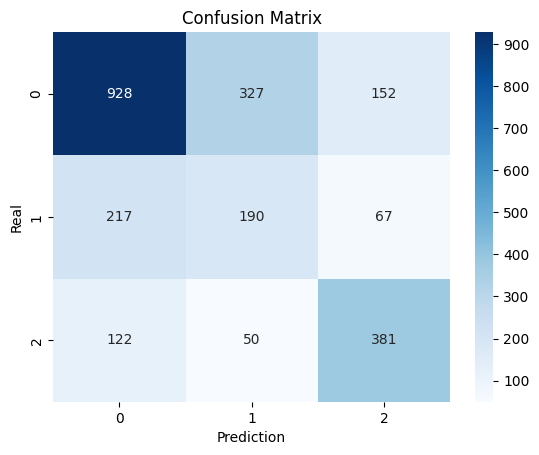

In [86]:
model = train_tfidf_logistic_regression_model(df, x_column="clean_text", y_column="label")

### Two classes

              precision    recall  f1-score   support

           0      0.724     0.753     0.738      1408
           1      0.641     0.606     0.623      1026

    accuracy                          0.691      2434
   macro avg      0.683     0.680     0.681      2434
weighted avg      0.689     0.691     0.690      2434



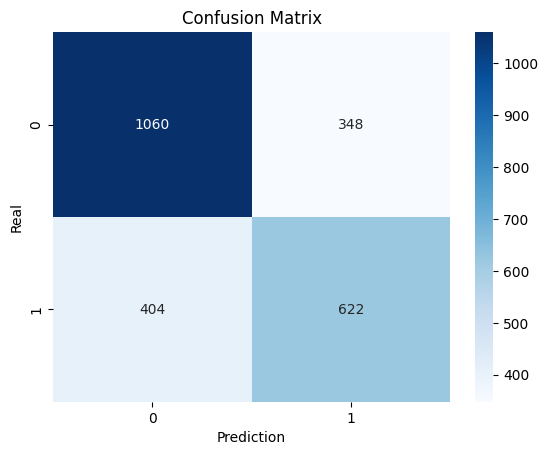

In [87]:
model = train_tfidf_logistic_regression_model(df_2c, x_column="clean_text", y_column="label")

## Balanced Classes

              precision    recall  f1-score   support

           0      0.728     0.726     0.727      1407
           1      0.358     0.352     0.355       474
           2      0.658     0.671     0.664       553

    accuracy                          0.641      2434
   macro avg      0.581     0.583     0.582      2434
weighted avg      0.640     0.641     0.641      2434



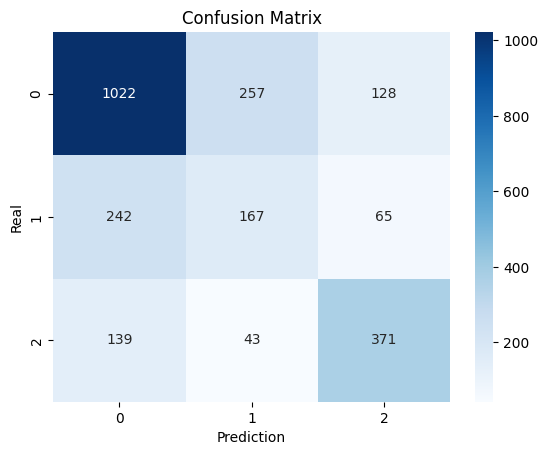

In [62]:
model = train_tfidf_logistic_regression_model(df, x_column="clean_text", y_column="label", balanced=True)

### Two classes

              precision    recall  f1-score   support

           0      0.717     0.793     0.753      1408
           1      0.668     0.571     0.616      1026

    accuracy                          0.700      2434
   macro avg      0.693     0.682     0.685      2434
weighted avg      0.697     0.700     0.695      2434



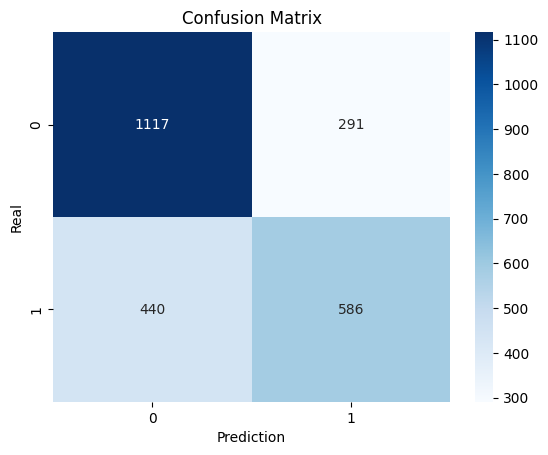

In [71]:
model = train_tfidf_logistic_regression_model(df_2c, x_column="clean_text", y_column="label", balanced=True)

# Embeddings with LSTM

In [88]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

Label distribution in the full dataset:
label
0    0.578320
2    0.227071
1    0.194609
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.5763173475429249), 1: np.float64(1.7131291798662442), 2: np.float64(1.4681749622926092)}


d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 170s 601ms/step - accuracy: 0.4205 - loss: 1.0920 - val_accuracy: 0.2649 - val_loss: 1.0829
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 145s 530ms/step - accuracy: 0.3703 - loss: 1.0257 - val_accuracy: 0.5462 - val_loss: 0.9732
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 509ms/step - accuracy: 0.5248 - loss: 0.8607 - val_accuracy: 0.4425 - val_loss: 0.9451
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 152s 553ms/step - accuracy: 0.5586 - loss: 0.7557 - val_accuracy: 0.4425 - val_loss: 0.9666
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 520ms/step - accuracy: 0.5753 - loss: 0.6930 - val_accuracy: 0.5770 - val_loss: 0.9811
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 144s 524ms/step - accuracy: 0.6119 - loss: 0.6427 - val_accuracy: 0.5021 - val_loss: 1.0220
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step

--- Improved LSTM Model Evaluation ---
              precision    recall  f1-score   support

   Score 0.0      0.697     0.335     0.452      1407
   Score 0.7      

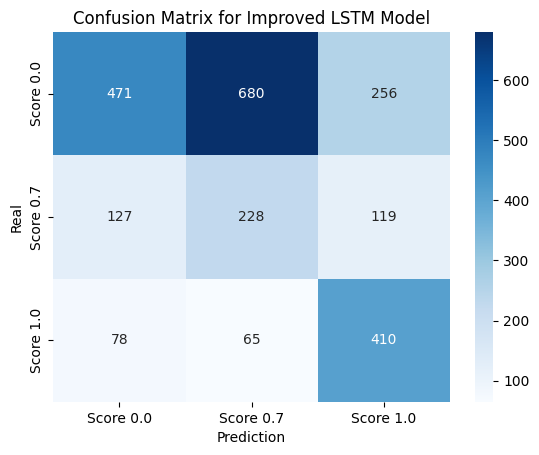

In [89]:
print("Label distribution in the full dataset:")
print(df['label'].value_counts(normalize=True))

X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

VOCAB_SIZE = 10000
MAX_LENGTH = 150
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights_dict)


model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4) # 0.0001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

EPOCHS = 20
BATCH_SIZE = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Model evaluation
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- Improved LSTM Model Evaluation ---")
print(classification_report(y_test, y_pred, target_names=['Score 0.0', 'Score 0.7', 'Score 1.0'], digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'],
            yticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'])
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix for Improved LSTM Model")
plt.show()

# Pretrained Embeddings

In [48]:
from sentence_transformers import SentenceTransformer

model_name = 'thenlper/gte-small'
embedding_model = SentenceTransformer(model_name)
print("Model loaded.")

print("\nGenerating embeddings for the training data...")
X_train_embeddings = embedding_model.encode(X_train, show_progress_bar=True)

print("\nGenerating embeddings for the test data...")
X_test_embeddings = embedding_model.encode(X_test, show_progress_bar=True)

print("\nShape of training embeddings:", X_train_embeddings.shape)
print("Shape of test embeddings:", X_test_embeddings.shape)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\juziu\.cache\huggingface\hub\models--thenlper--gte-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded.

Generating embeddings for the training data...


Batches:   0%|          | 0/305 [00:00<?, ?it/s]


Generating embeddings for the test data...


Batches:   0%|          | 0/77 [00:00<?, ?it/s]


Shape of training embeddings: (9734, 384)
Shape of test embeddings: (2434, 384)


## With XGBoost

In [90]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
print("\nTraining the XGBoost...")
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

classifier.fit(X_train_embeddings, y_train, sample_weight=sample_weights)
print("Classifier trained.")


Training the XGBoost...


d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:56:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classifier trained.



--- GTE-small Embeddings + XGBoost ---
              precision    recall  f1-score   support

   Score 0.0      0.666     0.747     0.704      1407
   Score 0.7      0.321     0.232     0.269       474
   Score 1.0      0.557     0.515     0.535       553

    accuracy                          0.594      2434
   macro avg      0.514     0.498     0.503      2434
weighted avg      0.574     0.594     0.581      2434



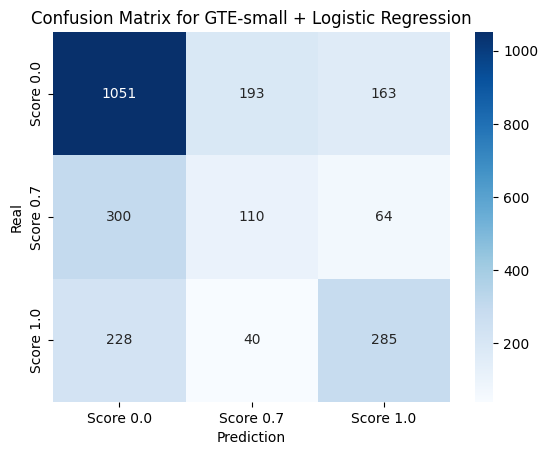

In [91]:
# Evaluation
print("\n--- GTE-small Embeddings + XGBoost ---")
y_pred = classifier.predict(X_test_embeddings)

print(classification_report(y_test, y_pred, target_names=['Score 0.0', 'Score 0.7', 'Score 1.0'], digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'],
            yticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'])
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix for GTE-small + Logistic Regression")
plt.show()

### Two classes

In [94]:
def convert_to_2c(y):
    return [0 if y_n == 0 else 1 for y_n in y]

In [100]:
classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

classifier.fit(X_train_embeddings, convert_to_2c(y_train), sample_weight=sample_weights)
print("Classifier trained.")

d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:05:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classifier trained.



--- GTE-small Embeddings + XGBoost 2 classes ---
              precision    recall  f1-score   support

   Score 0.0      0.700     0.595     0.643      1407
   Score 1.0      0.540     0.651     0.590      1027

    accuracy                          0.619      2434
   macro avg      0.620     0.623     0.617      2434
weighted avg      0.633     0.619     0.621      2434



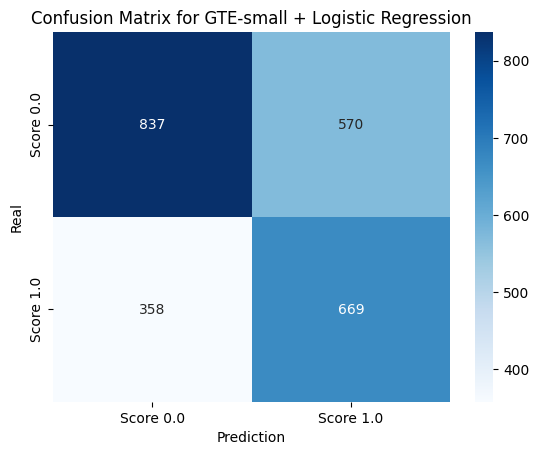

In [102]:
# Evaluation
print("\n--- GTE-small Embeddings + XGBoost 2 classes ---")
y_pred = classifier.predict(X_test_embeddings)

print(classification_report(convert_to_2c(y_test), y_pred, target_names=['Score 0.0', 'Score 1.0'], digits=3))

cm = confusion_matrix(convert_to_2c(y_test), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Score 0.0', 'Score 1.0'],
            yticklabels=['Score 0.0', 'Score 1.0'])
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix for GTE-small + Logistic Regression")
plt.show()

## With Neural Network

In [103]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Using class weights:", class_weights_dict)

mlp_classifier = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_embeddings.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

mlp_classifier.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mlp_classifier.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mlp_classifier.fit(
    X_train_embeddings,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Using class weights: {0: np.float64(0.5763173475429249), 1: np.float64(1.7131291798662442), 2: np.float64(1.4681749622926092)}


d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4731 - loss: 1.0956 - val_accuracy: 0.4559 - val_loss: 1.0907
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4215 - loss: 1.0885 - val_accuracy: 0.4281 - val_loss: 1.0885
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4299 - loss: 1.0763 - val_accuracy: 0.3871 - val_loss: 1.0699
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4508 - loss: 1.0543 - val_accuracy: 0.5021 - val_loss: 1.0438
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4840 - loss: 1.0277 - val_accuracy: 0.5544 - val_loss: 1.0120
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4946 - loss: 1.0030 - val_accuracy: 0.5298 - val_loss: 0.9991
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5110 - loss: 0.9856 - val_accuracy: 0.5185 - val_loss: 0.9869
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5197 - loss: 0.9681 - val_accuracy: 0.


--- GTE-small Embeddings + MLP Classifier Evaluation ---
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

   Score 0.0      0.692     0.704     0.698      1407
   Score 0.7      0.325     0.287     0.305       474
   Score 1.0      0.517     0.546     0.531       553

    accuracy                          0.587      2434
   macro avg      0.512     0.512     0.511      2434
weighted avg      0.581     0.587     0.584      2434



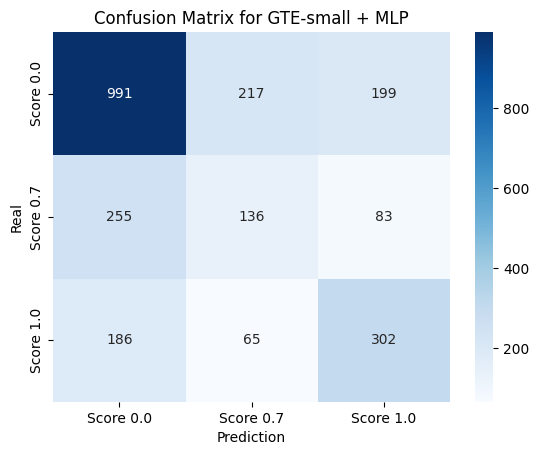

In [58]:
print("\n--- GTE-small Embeddings + MLP Classifier Evaluation ---")
y_pred_probs = mlp_classifier.predict(X_test_embeddings)
y_pred = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

print(classification_report(y_test, y_pred, target_names=['Score 0.0', 'Score 0.7', 'Score 1.0'], digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'],
            yticklabels=['Score 0.0', 'Score 0.7', 'Score 1.0'])
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix for GTE-small + MLP")
plt.show()

### Two classes

In [105]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(convert_to_2c(y_train)),
    y=convert_to_2c(y_train)
)
class_weights_dict = dict(enumerate(class_weights))
print("Using class weights:", class_weights_dict)

mlp_classifier = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_embeddings.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

mlp_classifier.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mlp_classifier.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mlp_classifier.fit(
    X_train_embeddings,
    np.array(convert_to_2c(y_train)),
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Using class weights: {0: np.float64(0.8644760213143872), 1: np.float64(1.185916179337232)}


d:\University\SEM_2\Advanced_Data_Mining\computational-intelligence-2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5126 - loss: 0.8221 - val_accuracy: 0.5986 - val_loss: 0.7066
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5058 - loss: 0.7161 - val_accuracy: 0.6396 - val_loss: 0.6915
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5352 - loss: 0.6997 - val_accuracy: 0.6478 - val_loss: 0.6834
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5430 - loss: 0.6924 - val_accuracy: 0.5554 - val_loss: 0.6850
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5529 - loss: 0.6864 - val_accuracy: 0.6099 - val_loss: 0.6760
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5719 - loss: 0.6802 - val_accuracy: 0.5965 - val_loss: 0.6709
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5965 - loss: 0.6687 - val_accuracy: 0.6314 - val_loss: 0.6584
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6168 - loss: 0.6602 - val_accuracy: 0.


--- GTE-small Embeddings + MLP Classifier Evaluation 2 classes ---
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

   Score 0.0      0.685     0.755     0.718      1407
   Score 1.0      0.609     0.524     0.563      1027

    accuracy                          0.657      2434
   macro avg      0.647     0.639     0.641      2434
weighted avg      0.653     0.657     0.653      2434



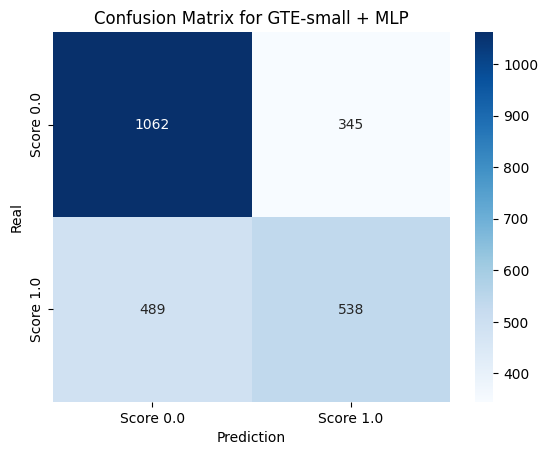

In [108]:
print("\n--- GTE-small Embeddings + MLP Classifier Evaluation 2 classes ---")
y_pred_probs = mlp_classifier.predict(X_test_embeddings)
y_pred = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

print(classification_report(convert_to_2c(y_test), y_pred, target_names=['Score 0.0', 'Score 1.0'], digits=3))

cm = confusion_matrix(convert_to_2c(y_test), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Score 0.0', 'Score 1.0'],
            yticklabels=['Score 0.0', 'Score 1.0'])
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix for GTE-small + MLP")
plt.show()